In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gzip
import dateutil
import scipy
import csv

In [2]:
DATA_DIR = Path("../data")

The following code code reads real PWV measurements for 2023 made using the Low Humidity And Temperature Profiling microwave radiometer at the Paranal Observatory, which have been retrieved trough the [LHATPRO Query Form](https://archive.eso.org/wdb/wdb/asm/lhatpro_paranal/form).

The graph below shows the available PWV data. It can be seen that occasional negative values are present. These have no physical meaning and are a result of errors in the data.

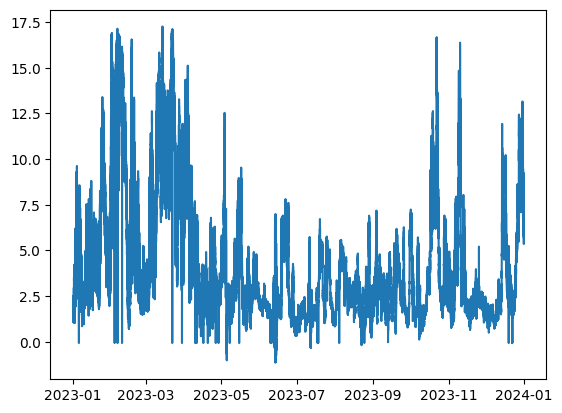

In [3]:
timestamps = []
pwv_values = []

with gzip.open(DATA_DIR / "wdb_query_eso.csv.gz", mode="rt", newline="") as fp:
	reader = csv.reader(fp)
	next(reader)
	next(reader)
	for row in reader:
		if len(row) == 3:
			p, t, pwv = row
			if pwv:
				t = dateutil.parser.parse(t)
				pwv = float(pwv)
				timestamps.append(t)
				pwv_values.append(pwv)

pwv_values = np.asarray(pwv_values)

plt.plot(timestamps, pwv_values)
plt.show()

The available PWV values follow a roughly log-normal distribution, a result consistent with previous [findings](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2005JD006731). Fitting a log-normal distribution to the data yields estimates of its parameters, which will be used later.

The graph below shows the real distribution of the data and compares it with the computed log-normal model.

d:\Documents\AIExperiments\venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2357: RuntimeWarning: overflow encountered in divide
  x = (x - loc) / scale


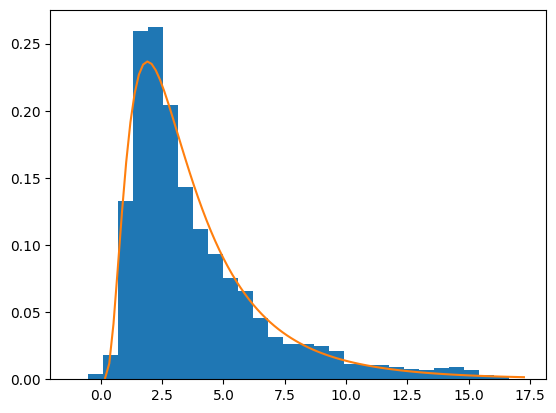

FitParams(s=0.6959811694048642, loc=0.0, scale=3.086260824880316)


In [4]:
plt.hist(pwv_values, bins=30, density=True)
#plt.show()

bounds = { "s": (0, 1), "scale": (0, 10) }
result = scipy.stats.fit(scipy.stats.lognorm, pwv_values, bounds=bounds)
params = result.params
distribution = scipy.stats.lognorm(*params)
span = np.arange(pwv_values.max(), step=pwv_values.max() / 100) + pwv_values.max() / 100
plt.plot(span, distribution.pdf(span))
plt.show()

print(params)

This stochastic process is such that $V_{k+1}=p \cdot V_k+R_{k+1}$, where $R_i$ variables are iid with distribution $\mathcal{N}(0,1)$ and $0 \le p<1$.

When $k$ is large, $\mathrm{Var}(V_k)$ converges to $\frac{1}{1-p^2}$, due to the properties of geometric series. If $V_0$ has this same variance too and is a normally-distributed random variable independent of all $R_i$ variables, then $\mathrm{Var}(V_k)$ is constant and the sampling can start at any point.

Any long segment of the generated sequence is expected to have the same mean and variance as that of any $V_k$. This is a consequence of the fact that any two elements which are sufficiently far away in the sequence are nearly independent.

Multiplying every element of the sequence by $\sqrt{1-p^2}$ results in a new sequence of variables $S_i$ with a variance and standard deviation of 1.

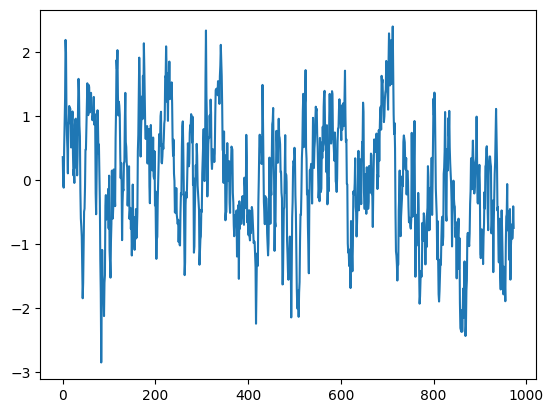

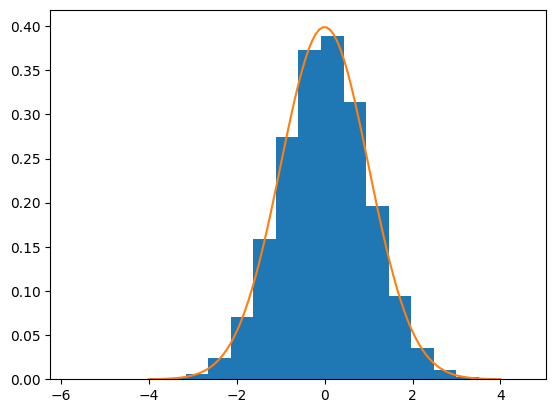

In [5]:
def random_process(size, p):
	random = np.random.normal(size=size)
	v = random[0] / np.sqrt(1 - p ** 2)
	sequence = [v]
	for r in random[1:]:
		v = v * p + r
		sequence.append(v)
	sequence = np.asarray(sequence)
	sequence *= np.sqrt(1 - p ** 2)
	return sequence

s = random_process(1000000, 0.9)

plt.plot(s[:974])
plt.show()

plt.hist(s, bins=20, density=True)
#plt.show()

x = np.linspace(-4, 4, 100)
plt.plot(x, scipy.stats.norm.pdf(x))
plt.show()

The expected difference between any two values of a sequence $S$ as decribed above is 0. However, its variance depends on their distance along the sequence.

$\mathrm{Var}(S_n - S_m)$ is 0 when $d=n-m=0$ (since they are really the same element) and then it grows monotonically with $d$. When $n \gg m$, $S_m$ and $S_n$ are nearly independent, so $S_n + (-S_m)$ is effectively the sum of two independent normally distributed random variables and its variance approaches 2, drawing a horizontal asymptote.

From the graph below it can be seen that the value of $p$ can be used to control the rate at which the standard deviation of the difference between two elements in the sequence grows with their distance: the lower $p$ is, the faster elements vary in the sequence.

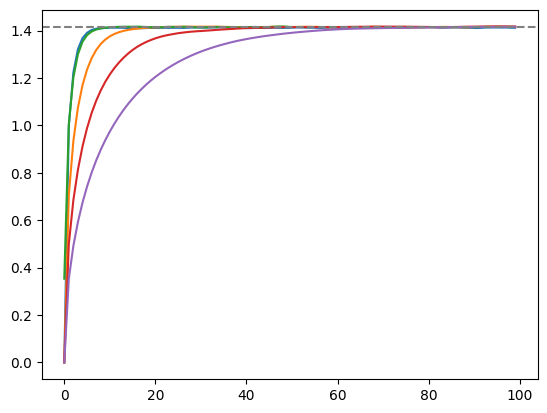

In [6]:
for exp in range(1, 5):
	sequence = random_process(1000000, 1 - 0.5 ** exp)
	stds = [0]
	for i in range(1, 100):
		diffs = sequence[i:] - sequence[:-i]
		std = np.sqrt(np.sum(diffs ** 2) / diffs.size)
		stds.append(std)
	stds = np.asarray(stds)
	plt.plot(stds)
	#plt.show()
	if exp == 2:
		stds_means = np.mean(stds.reshape(-1, 2), axis=1)
		plt.plot(stds_means)
		#plt.show()

plt.axhline(y=np.sqrt(2), linestyle="--", color="gray")

plt.show()

The following code generates a random sequence of fake PVW values. The values across the sequence will have a lognormal distribution. The parameters of the distribution and the pace of variation across the sequence must be set to realistic values.

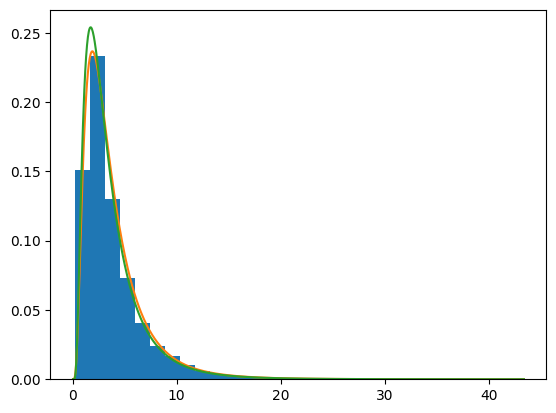

In [7]:
def random_pwv(size, dt=1, pace=1e4, s=0.69598, scale=3.0862):
	pace /= dt
	p = pace / (pace + 1)
	sequence = random_process(size, p)
	sequence *= s
	pwv = np.exp(sequence)
	pwv *= scale
	return pwv

pwv = random_pwv(10000000)

plt.hist(pwv, bins=30, density=True)
#plt.show()

distribution = scipy.stats.lognorm(0.69598, scale=3.0862)
span = np.arange(pwv.max(), step=pwv.max() / 1000) + pwv.max() / 1000
plt.plot(span, distribution.pdf(span))
#plt.show()

params = scipy.stats.lognorm.fit(pwv)
distribution = scipy.stats.lognorm(*params)
span = np.arange(pwv.max(), step=pwv.max() / 1000) + pwv.max() / 1000
plt.plot(span, distribution.pdf(span))
plt.show()

The following code shows the effect of the `pace` parameter on how fast values vary throughout the generated sequence.

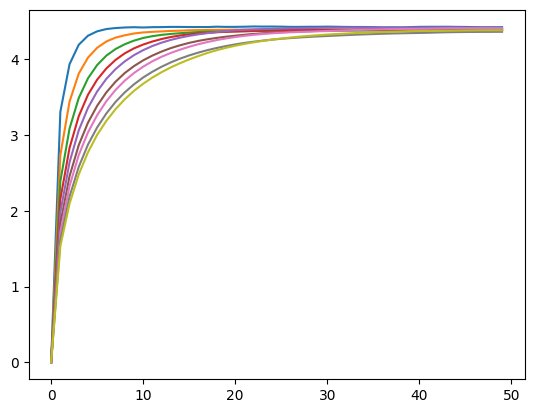

In [8]:
for pace in range(1, 10):
	pwv = random_pwv(1000000, pace=pace)
	stds = [0]
	for i in range(1, 50):
		diffs = pwv[i:] - pwv[:-i]
		std = np.sqrt(np.sum(diffs ** 2) / diffs.size)
		stds.append(std)
	stds = np.asarray(stds)
	plt.plot(stds)
	#plt.show()

plt.show()

In [16]:
instants = [(t - timestamps[0]).total_seconds() for t in timestamps]
instants = np.asarray(instants)

deltas = instants[1:] - instants[:-1]
plt.plot(deltas)
plt.show()

end = 0

intervals = []

for i in range(50):
	condition = np.logical_and(deltas < 500, np.arange(deltas.size) > end)
	cell = np.argmax(deltas[end:] > 500)
	begin = np.argmax(condition)
	end = np.argmin(condition[begin + 1:]) + begin + 1
	print(begin, end, cell)
	assert condition[begin : end].all()

	if end > begin + 120:
		interval_x = instants[begin : end + 1]
		interval_y = pwv_values[begin : end + 1]

		intervals.append((interval_x, interval_y))

interval_x, interval_y = intervals[0]

plt.plot(interval_x)
plt.show()

plt.plot(interval_x, interval_y)
plt.show()

28448.0

In [48]:
cond = deltas > 500
indices = np.empty(pwv_values.size, dtype=np.int32)

count = 0

indices[0] = 0

for i in range(cond.size):
	count += cond[i]
	indices[i + 1] = count

n_intervals = indices[-1]

intervals = []

for i in range(1, n_intervals):
	selected = indices == i
	if selected.sum() >= 10:
		interval_x = instants[selected]
		interval_y = pwv_values[selected]
		intervals.append((interval_x, interval_y))

for i in range(500):
	print(i, sum(i_x.size >= i for i_x, i_y in intervals))

0 1520
1 1520
2 1520
3 1520
4 1520
5 1520
6 1520
7 1520
8 1520
9 1520
10 1520
11 1474
12 1426
13 1280
14 1248
15 1214
16 1179
17 907
18 854
19 838
20 827
21 813
22 801
23 772
24 622
25 614
26 609
27 595
28 589
29 585
30 579
31 573
32 565
33 558
34 551
35 544
36 540
37 535
38 533
39 525
40 492
41 488
42 488
43 486
44 485
45 480
46 474
47 467
48 465
49 463
50 463
51 462
52 461
53 455
54 453
55 451
56 439
57 438
58 437
59 435
60 434
61 434
62 432
63 424
64 422
65 420
66 420
67 419
68 415
69 414
70 413
71 411
72 408
73 407
74 405
75 403
76 402
77 400
78 399
79 394
80 392
81 391
82 390
83 390
84 390
85 387
86 387
87 387
88 386
89 385
90 385
91 385
92 385
93 384
94 384
95 381
96 381
97 381
98 380
99 379
100 378
101 376
102 375
103 374
104 374
105 374
106 374
107 373
108 372
109 372
110 372
111 372
112 371
113 370
114 370
115 369
116 369
117 369
118 367
119 366
120 366
121 366
122 366
123 364
124 364
125 364
126 364
127 363
128 362
129 361
130 361
131 360
132 359
133 358
134 357
135 357
136 3

The following code exemplifies the generation of PWV sequences with a duration of 5 hours represented trough 59 samples.

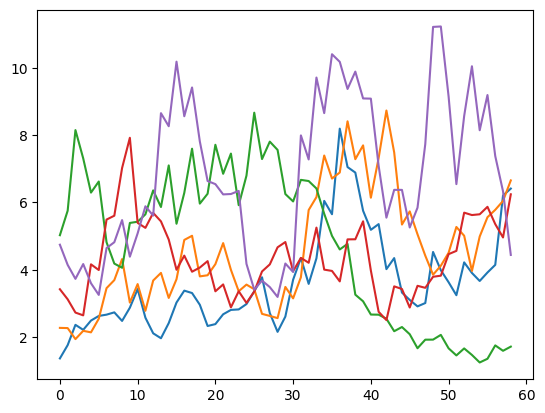

In [8]:
timespan = 5 * 60 * 60
size = 59

for i in range(5):
	pwv = random_pwv(size, dt=timespan / size)
	plt.plot(pwv)
	#plt.show()

plt.show()